In [ ]:
import sys
import os
sys.path.append(os.path.abspath("/home/lumasty/Documents/GitHub/MAFinancialAssistance"))


from DBAgent.Querier import Querier
from SearchAgent.Searcher import Searcher

# Initialize Querier and Searcher
querier = Querier()
searcher = Searcher()

In [2]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv


load_dotenv(override=True)

base_model = os.getenv("MODEL")
base_api = os.getenv("BASE_API")
base_url = os.getenv("BASE_URL")

    

llm = ChatGoogleGenerativeAI(model=base_model, google_api_key=base_api, temperature=0)

In [30]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["querier", "researcher"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor managing two specialized AI workers: {member}.\n\n"
    
    "The user will provide a high-level request or question. Your job is to:\n"
    "1. Break the user request into smaller sub-tasks.\n"
    "2. Assign each sub-task to the appropriate worker.\n"
    "   - Use 'researcher' for internet searches, general knowledge, current events, or finding external facts.\n"
    "   - Use 'querier' to query internal databases, perform data lookups, or analyze structured data.\n"
    "3. Route the next unfinished sub-task to the correct agent.\n"
    "4. When all sub-tasks have been completed, respond with 'FINISH'.\n\n"

    "Return ONLY one of the following:\n"
    "- 'researcher' → if the next task requires internet research.\n"
    "- 'querier' → if the next task requires querying internal databases.\n"
    "- 'FINISH' → if all work is complete.\n\n"

    "You will receive the full conversation history, including user input and agent outputs. Use that to determine what has already been done and what remains.\n"
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



from typing import List, Optional

class State(MessagesState):
    next: str
    pending_tasks: Optional[List[str]] = None
    completed_tasks: Optional[List[str]] = None



def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    # First time: plan tasks
    if state.get("pending_tasks") is None:
        planning_prompt = (
            system_prompt +
            "\n\nBased on the user request, list the subtasks needed and which agent should handle each one."
            "\nReturn a JSON list like: [{\"task\": \"...\", \"agent\": \"searcher\"}, ...]"
        )
        planning_response = llm.invoke(messages + [{"role": "user", "content": "List subtasks"}])
        # Example: [{"task": "Get average spending in Vietnam", "agent": "searcher"}, {"task": "Fetch account 0 consumption", "agent": "querier"}]
        task_plan = eval(planning_response.content)  # or use structured output parsing here
        state["pending_tasks"] = task_plan
        state["completed_tasks"] = []

    # Get next task
    if state["pending_tasks"]:
        next_task = state["pending_tasks"].pop(0)
        next_agent = next_task["agent"]
        task_message = HumanMessage(content=next_task["task"], name="supervisor")

        return Command(
            goto=next_agent,
            update={
                "messages": [task_message],
                "next": next_agent,
                "pending_tasks": state["pending_tasks"],
                "completed_tasks": state["completed_tasks"]
            }
        )

    return Command(goto=END, update={"next": "FINISH"})


In [12]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [13]:
!export TAVILY_API_KEY="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"

In [14]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    latest_message = state["messages"][-1].content
    result = querier.execute_query(latest_message)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="querier")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("querier", code_node)
graph = builder.compile()

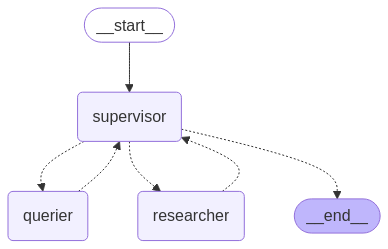

In [32]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
for s in graph.stream(
    {"messages": [("user", "Compare my money consumption with average money consumption of Vietnamese people. My account ID is 0.")]}, subgraphs=True
):
    print(s)
    print("----")

SyntaxError: unterminated string literal (detected at line 3) (<string>, line 3)

In [22]:
import uuid
query = "Compare my money consumption with average money consumption of Vietnamese people. My account ID is 0."
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}
# events = self.graph.stream(
#     {"messages": [("user", query)]}, config, stream_mode="values"
# )
# for event in events:
#     _print_event(event, _printed)
msg = {"messages": [("user", query)]}
messages = graph.invoke(msg,config)
# print(messages['messages'][-1].content)

/home/lumasty/Documents/GitHub/MAFinancialAssistance/venv/lib64/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


Compare my money consumption with average money consumption of Vietnamese people. My account ID is 0.
{'messages': [HumanMessage(content='Compare my money consumption with average money consumption of Vietnamese people. My account ID is 0.', additional_kwargs={}, response_metadata={}, id='b2c4e0ba-b5b0-4471-be07-38bfd9fb2434'), AIMessage(content="I need to find the money consumption for your account and the average money consumption of Vietnamese people. I'll start by listing the tables in the database to see what tables I can query.", additional_kwargs={'function_call': {'name': 'sql_db_list_tables', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-c1d61262-a7b1-4784-9abf-6d8d017fa485-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '038cf34c-940a-4df7-a7da-4cbf964bc15b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 69

/home/lumasty/Documents/GitHub/MAFinancialAssistance/venv/lib64/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(
/home/lumasty/Documents/GitHub/MAFinancialAssistance/venv/lib64/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


In [24]:
print(messages['messages'][-1].content)

Okay, I have some information about average consumption expenditure in Vietnam. According to Statista, the household consumption expenditure per capita in Vietnam was approximately 2,082 U.S. dollars in 2022.

I also have the information that your money consumption is 26467.00 and the average money consumption of other users is 245373.89.

Please note that I am unable to perform any mathematical calculations or currency conversions.


In [ ]:

from typing import Literal, List
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END

members = ["querier", "searcher"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor managing specialized AI workers: {members}.\n\n"
    "The user will provide a request. Your job is to:\n"
    "1. Break the request into clear sub-tasks\n"
    "2. Assign each sub-task to the best worker\n"
    "3. Route ONE sub-task at a time\n"
    "4. Finalize when all tasks are complete\n\n"
    "Workers:\n"
    "- searcher: Web searches, current events, external facts\n"
    "- querier: Internal database queries, structured data\n\n"
    "Respond ONLY with one of: {options}"
).format(members=", ".join(members), options=", ".join(options))

class Router(TypedDict):
    next: Literal[*options]

class State(MessagesState):
    subtasks: List[str] = []
    current_task: str = None

class GraphBuilder():
    def __init__(self, llm, querier, searcher):
        self.llm = llm
        self.querier = querier
        self.searcher = searcher

    def create_initial_state(self, user_input: str):
        return State(
            messages=[HumanMessage(content=user_input)],
            subtasks=[],
            current_task=None
        )

    def supervisor_node(self, state: State) -> Command[Literal[*members, "__end__"]]:
        # Format system message with current state
        sys_message = SystemMessage(content=system_prompt)
        messages = [sys_message] + state["messages"]
        
        if state["subtasks"]:
            messages.append(SystemMessage(
                content=f"Remaining sub-tasks: {', '.join(state['subtasks'])}"
            ))
        
        # Get supervisor decision
        decision = self.llm.with_structured_output(Router).invoke(messages)
        next_step = decision["next"]
        
        # Update state
        updates = {}
        if next_step == "FINISH":
            return Command(goto=END, update=updates)
        
        if not state["subtasks"]:
            # First run - generate initial subtasks
            task_list = self.llm.invoke([
                sys_message,
                HumanMessage(content="List sub-tasks for this request (numbered)"),
                SystemMessage(content="ONLY return a numbered list, nothing else")
            ]).content
            updates["subtasks"] = [t.split(". ")[1] for t in task_list.split("\n") if t]
        
        if state["subtasks"]:
            updates["current_task"] = state["subtasks"].pop(0)
            
        return Command(
            goto=next_step if next_step in members else "supervisor",
            update=updates
        )

    def agent_node(self, agent_name: str):
        def execute_agent(state: State):
            task = state["current_task"]
            if agent_name == "searcher":
                result = research_agent.invoke(state)
                result=result["messages"][-1].content
            else:
                result = self.querier.execute_query(task)
                result=result["messages"][-1].content
            return Command(
                update={
                    "messages": [HumanMessage(content=result, name=agent_name)],
                    "current_task": None
                },
                goto="supervisor"
            )
        return execute_agent

    def build_graph(self):
        builder = StateGraph(State)
        
        # Add nodes
        builder.add_node("supervisor", self.supervisor_node)
        builder.add_node("searcher", self.agent_node("searcher"))
        builder.add_node("querier", self.agent_node("querier"))
        
        # Set up edges
        builder.add_edge(START, "supervisor")
        
        # Conditional edge from supervisor
        builder.add_conditional_edges(
            "supervisor",
            lambda state: state.get("next") or "supervisor",
            {
                "searcher": "searcher",
                "querier": "querier",
                "FINISH": END,
                "supervisor": "supervisor"  # Fallback
            }
        )
        
        # Regular edges from agents back to supervisor
        builder.add_edge("searcher", "supervisor")
        builder.add_edge("querier", "supervisor")
        
        return builder.compile()

In [35]:
graph = GraphBuilder(llm, querier, searcher).build_graph()

In [39]:
for s in graph.stream(
    {"messages": [("user", "Compare my money consumption with average money consumption of Vietnamese people. My account ID is 0.")]}, subgraphs=True
):
    print(s)
    print("----")

KeyError: 'subtasks'